**Trains Monte-Carlo (first-visit), SARSA (TD on-policy), and Q-Learning (TD off-policy) on the same FrozenLake-v1 environment.**

In [12]:
!pip install gymnasium

In [13]:
# Combined MC (first-visit), SARSA, and Q-Learning on FrozenLake-v1 (slippery=True)
# Paste into a Colab cell or run locally (Python 3.8+)
# Requirements: pip install gymnasium matplotlib

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import random
import warnings
warnings.filterwarnings("ignore")


In [14]:
# -----------------------
# Environment & Helpers
# -----------------------
ENV_NAME = "FrozenLake-v1"
env_kwargs = {"map_name": "4x4", "is_slippery": True}
env = gym.make(ENV_NAME, **env_kwargs)
n_states = env.observation_space.n
n_actions = env.action_space.n

def eps_greedy_action(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    else:
        return int(np.argmax(Q[state]))

def policy_from_Q(Q):
    """Return greedy action for each state (int)."""
    return np.argmax(Q, axis=1)

def print_policy(policy):
    # Map actions to arrows: 0=Left,1=Down,2=Right,3=Up (FrozenLake convention)
    arrows = {0: '<', 1: 'v', 2: '>', 3: '^'}
    policy_symbols = [arrows[a] for a in policy]
    # Print 4x4 grid
    print("Greedy policy (4x4):")
    for i in range(0, 16, 4):
        print(" ".join(policy_symbols[i:i+4]))
    print()


In [15]:
# -----------------------
# 1) First-Visit Monte-Carlo Control
# -----------------------
def mc_first_visit(env, num_episodes=20000, gamma=0.99, epsilon_start=1.0, epsilon_end=0.1):
    Q = np.zeros((n_states, n_actions), dtype=np.float64)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    rewards_history = []

    for ep in range(1, num_episodes+1):
        # decay epsilon
        epsilon = max(epsilon_end, epsilon_start * (1 - ep/num_episodes))
        # generate an episode (list of (s,a,r))
        episode = []
        state, info = env.reset(seed=None)
        while True:
            action = eps_greedy_action(Q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if terminated or truncated:
                break

        # Calculate returns and apply first-visit updates
        G = 0.0
        visited = set()
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = gamma * G + r
            if (s, a) not in visited:
                visited.add((s, a))
                returns_sum[(s, a)] += G
                returns_count[(s, a)] += 1.0
                Q[s, a] = returns_sum[(s, a)] / returns_count[(s, a)]

        # episode reward is sum of rewards (in FrozenLake usually 0 or 1)
        ep_reward = sum([r for (_, _, r) in episode])
        rewards_history.append(ep_reward)

    return Q, rewards_history


In [16]:
# -----------------------
# 2) SARSA (on-policy TD)
# -----------------------
def sarsa(env, num_episodes=20000, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_end=0.1):
    Q = np.zeros((n_states, n_actions), dtype=np.float64)
    rewards_history = []
    for ep in range(1, num_episodes+1):
        epsilon = max(epsilon_end, epsilon_start * (1 - ep/num_episodes))
        state, info = env.reset(seed=None)
        action = eps_greedy_action(Q, state, epsilon)
        ep_reward = 0
        while True:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = eps_greedy_action(Q, next_state, epsilon)
            # TD update
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            state, action = next_state, next_action
            ep_reward += reward
            if terminated or truncated:
                break
        rewards_history.append(ep_reward)
    return Q, rewards_history

In [17]:
# 3) Q-Learning (off-policy TD)

def q_learning(env, num_episodes=20000, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_end=0.1):
    Q = np.zeros((n_states, n_actions), dtype=np.float64)
    rewards_history = []
    for ep in range(1, num_episodes+1):
        epsilon = max(epsilon_end, epsilon_start * (1 - ep/num_episodes))
        state, info = env.reset(seed=None)
        ep_reward = 0
        while True:
            action = eps_greedy_action(Q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            # Q-learning update - uses max over next actions
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
            state = next_state
            ep_reward += reward
            if terminated or truncated:
                break
        rewards_history.append(ep_reward)
    return Q, rewards_history

Training Monte-Carlo (first-visit)...
Training SARSA (on-policy TD)...
Training Q-Learning (off-policy TD)...


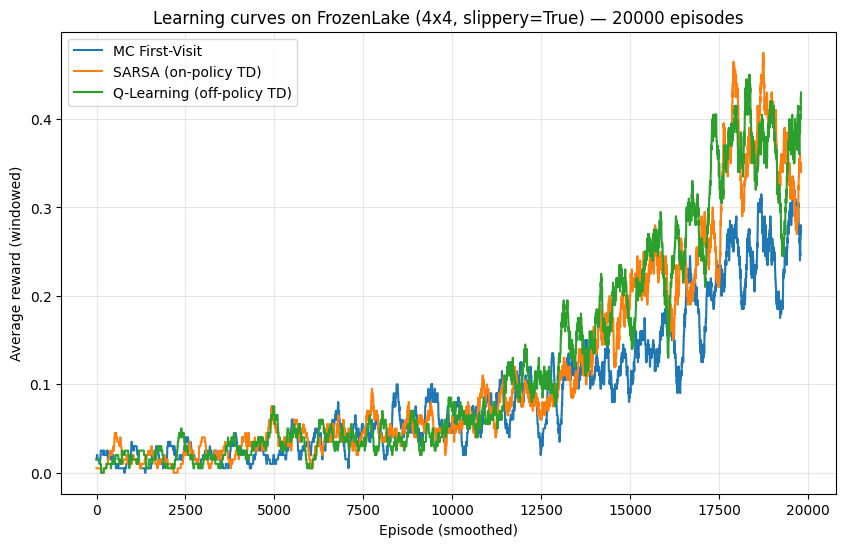

In [18]:
# -----------------------
# Run experiments
# -----------------------
NUM_EPISODES = 20000  # increase for better convergence

print("Training Monte-Carlo (first-visit)...")
Q_mc, rewards_mc = mc_first_visit(env, num_episodes=NUM_EPISODES)

print("Training SARSA (on-policy TD)...")
Q_sarsa, rewards_sarsa = sarsa(env, num_episodes=NUM_EPISODES)

print("Training Q-Learning (off-policy TD)...")
Q_q, rewards_q = q_learning(env, num_episodes=NUM_EPISODES)

# -----------------------
# Plot learning curves (smoothed)
# -----------------------
def smooth(x, window=200):
    if len(x) < window:
        return np.array(x)
    return np.convolve(x, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10,6))
sm_mc = smooth(rewards_mc, window=200)
sm_sarsa = smooth(rewards_sarsa, window=200)
sm_q = smooth(rewards_q, window=200)
plt.plot(np.arange(len(sm_mc)), sm_mc, label='MC First-Visit')
plt.plot(np.arange(len(sm_sarsa)), sm_sarsa, label='SARSA (on-policy TD)')
plt.plot(np.arange(len(sm_q)), sm_q, label='Q-Learning (off-policy TD)')
plt.xlabel('Episode (smoothed)')
plt.ylabel('Average reward (windowed)')
plt.title(f'Learning curves on FrozenLake (4x4, slippery=True) — {NUM_EPISODES} episodes')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [19]:
# -----------------------
# Print final Q-tables and greedy policies
# -----------------------
np.set_printoptions(precision=3, suppress=True)
print("\nFinal Q-table (MC first-visit):\n", Q_mc)
print_policy(policy_from_Q(Q_mc))

print("Final Q-table (SARSA):\n", Q_sarsa)
print_policy(policy_from_Q(Q_sarsa))

print("Final Q-table (Q-Learning):\n", Q_q)
print_policy(policy_from_Q(Q_q))

# Also print average episodic rewards (last 1000 episodes mean)
def last_mean(arr, k=1000):
    return np.mean(arr[-k:]) if len(arr) >= k else np.mean(arr)
print("Average reward (last 1000 episodes):")
print("MC:", last_mean(rewards_mc))
print("SARSA:", last_mean(rewards_sarsa))
print("Q-Learning:", last_mean(rewards_q))




Final Q-table (MC first-visit):
 [[0.053 0.048 0.087 0.045]
 [0.026 0.033 0.033 0.087]
 [0.067 0.064 0.098 0.058]
 [0.044 0.035 0.043 0.086]
 [0.122 0.058 0.047 0.041]
 [0.    0.    0.    0.   ]
 [0.132 0.092 0.093 0.022]
 [0.    0.    0.    0.   ]
 [0.059 0.097 0.08  0.188]
 [0.143 0.31  0.185 0.111]
 [0.264 0.32  0.22  0.078]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.179 0.302 0.48  0.238]
 [0.429 0.729 0.609 0.517]
 [0.    0.    0.    0.   ]]
Greedy policy (4x4):
> ^ > ^
< < < <
^ v v <
< > v <

Final Q-table (SARSA):
 [[0.259 0.249 0.247 0.251]
 [0.196 0.159 0.136 0.242]
 [0.232 0.16  0.166 0.169]
 [0.065 0.068 0.113 0.155]
 [0.304 0.199 0.105 0.133]
 [0.    0.    0.    0.   ]
 [0.233 0.102 0.135 0.071]
 [0.    0.    0.    0.   ]
 [0.16  0.258 0.273 0.391]
 [0.253 0.44  0.348 0.245]
 [0.502 0.462 0.248 0.154]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.337 0.354 0.537 0.418]
 [0.575 0.781 0.693 0.64 ]
 [0.    0.    0.    0.   ]]
Greedy policy (4x4):
<

In [26]:
# -----------------------
# Evaluate & record videos for each learned Q
# -----------------------
from gymnasium.wrappers import RecordVideo
import os
import glob
from IPython.display import Video, display

video_folder = "./videos"
os.makedirs(video_folder, exist_ok=True)

def evaluate_and_record(Q, filename_prefix, max_steps=100):
    """
    Q: learned Q-table (n_states x n_actions)
    filename_prefix: string prefix for saved video file
    """
    # Make eval env with rgb_array render mode
    eval_env = gym.make(ENV_NAME, render_mode="rgb_array", **env_kwargs)
    # Wrap for recording
    eval_env = RecordVideo(eval_env, video_folder=video_folder, name_prefix=filename_prefix)

    obs, info = eval_env.reset(seed=42)
    state = obs
    total_reward = 0
    for t in range(max_steps):
        # greedy action from Q
        action = int(np.argmax(Q[state]))
        next_state, reward, terminated, truncated, info = eval_env.step(action)
        total_reward += reward
        state = next_state
        if terminated or truncated:
            break

    # Close the recording env to flush and write video
    eval_env.close()

    # Find the recorded video file (pick the most recent with the prefix)
    files = sorted(glob.glob(f"{video_folder}/{filename_prefix}*.mp4"), key=os.path.getmtime)
    if len(files) == 0:
        print(f"No video found for prefix {filename_prefix}")
        return None
    latest = files[-1]
    print(f"Saved video: {latest}  (total_reward={total_reward})")
    return latest

print("\nRecording evaluation videos (one per algorithm) — this may take a few seconds...")
mc_vid = evaluate_and_record(Q_mc, "mc_eval")
sarsa_vid = evaluate_and_record(Q_sarsa, "sarsa_eval")
qlearn_vid = evaluate_and_record(Q_q, "qlearn_eval")

# Display videos inside Colab (if available)
for p in [mc_vid, sarsa_vid, qlearn_vid]:
    if p is not None:
        display(Video(p, embed=True))


Recording evaluation videos (one per algorithm) — this may take a few seconds...
Saved video: ./videos/mc_eval-episode-0.mp4  (total_reward=1)
Saved video: ./videos/sarsa_eval-episode-0.mp4  (total_reward=1)
Saved video: ./videos/qlearn_eval-episode-0.mp4  (total_reward=1)
